In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

### Loading the Data

In [3]:
data = pd.read_csv("C:/Users/user/Documents/Bell/Datasets/AutoDS/trustpilot population.csv")
data['EXPOSURE_DATE'] = pd.to_datetime(data['EXPOSURE_DATE'])
data.sort_values(by='EXPOSURE_DATE', inplace=True)

print(data.shape)
data.head(10)

(115344, 5)


,USER_ID,EXPOSURE_DATE,VARIANT,KPI_ACTION,KPI_DATE
74718,3291264.0,2025-05-21 00:00:09,"""Variation-1""",0,NaN
39805,3291158.0,2025-05-21 00:00:18,"""Variation-1""",0,NaN
75361,3291272.0,2025-05-21 00:00:24,"""Variation-1""",0,NaN
87301,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-30 23:40:04.000
66538,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-31 00:17:42.000
16207,3291257.0,2025-05-21 00:00:41,"""Control""",1,2025-05-21 00:04:18.000
6398,3291273.0,2025-05-21 00:00:42,"""Control""",0,NaN
96741,3291272.0,2025-05-21 00:00:46,"""Variation-1""",0,NaN
16206,3291257.0,2025-05-21 00:01:12,"""Control""",1,2025-05-21 00:04:18.000
18452,3291272.0,2025-05-21 00:01:15,"""Variation-1""",0,NaN


In [4]:
data_control = data[data['VARIANT'] == '"Control"']
data_treatment = data[data['VARIANT'] == '"Variation-1"']

print(f'Control   - Number of samples: {data_control.shape[0]}')
print(f'Treatment - Number of samples: {data_treatment.shape[0]}')

Control   - Number of samples: 57661
Treatment - Number of samples: 57683


### Regular one-sided T-test (not sequential)

In [5]:
alpha = 0.05
beta = 0.2
p_base = 0.3
MDL = 0.025
MDE = p_base * MDL
sigma = np.sqrt(p_base*(1-p_base))

N = 2 * (sigma * (norm.ppf(1-alpha) + norm.ppf(1-beta)) / MDE)**2
N = int(np.ceil(N))
print(f'Number of samples required in each group: {N}')

Number of samples required in each group: 46164


In [6]:
Y_control = data_control.iloc[:N]['KPI_ACTION']
Y_treatment = data_treatment.iloc[:N]['KPI_ACTION']

mean_control = Y_control.mean()
mean_treatment = Y_treatment.mean()

n_control = Y_control.shape[0]
n_treatment = Y_treatment.shape[0]

print(f'Control   - Mean: {mean_control:.4f}, Number of samples: {n_control}')
print(f'Treatment - Mean: {mean_treatment:.4f}, Number of samples: {n_treatment}')

std_control = Y_control.std()
std_treatment = Y_treatment.std()
std_difference = np.sqrt((std_treatment**2 / n_treatment) + (std_control**2 / n_control))

print(f'\nObserved lift: {mean_treatment / mean_control - 1:.2%}')

t_statistic = (mean_treatment - mean_control) / std_difference
p_value = 1 - norm.cdf(t_statistic)

print(f'\nt-statistic: {t_statistic:.3f}')
print(f'p-value: {p_value:.3f}')

Control   - Mean: 0.3039, Number of samples: 46164
Treatment - Mean: 0.3082, Number of samples: 46164

Observed lift: 1.40%

t-statistic: 1.407
p-value: 0.080


### Sequential

In [7]:
design = {'fb': [-2.0206408409400276,
  -1.4707036032594498,
  -1.0732569645904761,
  -0.743251234434765,
  -0.45487107273772087,
  -0.1954083140723849,
  0.04257918914093326,
  0.26390860462831767,
  0.4719279542742342,
  0.6691190062543414,
  0.8575163049993835,
  1.03918634140849,
  1.2173221479798773,
  1.4004097678324625,
  1.6334665423394543],
 'eb': [4.1762944030231255,
  3.7025230171140833,
  3.412425304852192,
  3.1895681348267497,
  3.0031218982900745,
  2.8399266737175886,
  2.6929234835783804,
  2.5577649883333042,
  2.431459298875911,
  2.311681621991688,
  2.196258000806301,
  2.082528128444262,
  1.9659412442753499,
  1.8350075992575465,
  1.6334665423394543],
 'ppl': 0.07516559068404118}

futility_bound = design['fb']
efficacy_bound = design['eb']
ppl = design['ppl']
looks = len(futility_bound)

In [8]:
stats_sequence = []

for i in range(looks):
    current_size = int((i+1) * ppl * N + 1)
    Y_control = data_control.iloc[:current_size]['KPI_ACTION']
    Y_treatment = data_treatment.iloc[:current_size]['KPI_ACTION']

    mean_control = Y_control.mean()
    mean_treatment = Y_treatment.mean()

    std_control = Y_control.std()
    std_treatment = Y_treatment.std()
    std_difference = np.sqrt((std_treatment**2 / current_size) + (std_control**2 / current_size))

    statistic = (mean_treatment - mean_control) / std_difference
    stats_sequence.append(statistic)

    # if statistic > efficacy_bound[i]:
    #     print('Efficacy reached')
    #     break
    # elif statistic < futility_bound[i]:
    #     print('Futility reached')
    #     break

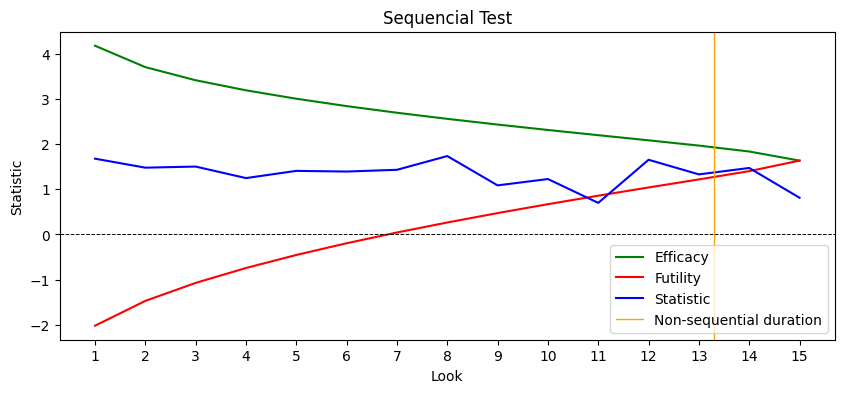

Each group's size grows by 3470 samples each look.


In [9]:
plt.figure(figsize=(10, 4))

x = np.arange(1, looks+1)

plt.plot(x, efficacy_bound, color='g', label='Efficacy')
plt.plot(x, futility_bound, color='r', label='Futility')
plt.plot(x[:len(stats_sequence)], stats_sequence, color='b', label='Statistic')

plt.axvline(x=1/ppl, color='orange', linestyle='-', linewidth=1, label='Non-sequential duration')
# plt.axvline(x=11, color='purple', linestyle='-', linewidth=1, label='Sequentail duration')

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.7)
plt.title('Sequencial Test')
plt.xlabel('Look')
plt.ylabel('Statistic')
plt.xticks(x)
plt.legend(loc='lower right')
plt.show()

print(f'Each group\'s size grows by {int(ppl*N+1)} samples each look.')

In [10]:
15/(1/ppl)

1.1274838602606176

In [11]:
data_control.iloc[:int(11*ppl*N)]

,USER_ID,EXPOSURE_DATE,VARIANT,KPI_ACTION,KPI_DATE
87301,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-30 23:40:04.000
66538,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-31 00:17:42.000
16207,3291257.0,2025-05-21 00:00:41,"""Control""",1,2025-05-21 00:04:18.000
6398,3291273.0,2025-05-21 00:00:42,"""Control""",0,NaN
16206,3291257.0,2025-05-21 00:01:12,"""Control""",1,2025-05-21 00:04:18.000
...,...,...,...,...,...
44364,2395644.0,2025-05-29 19:53:14,"""Control""",1,2025-05-29 19:59:22.000
62859,3279139.0,2025-05-29 19:53:53,"""Control""",0,NaN
9446,NaN,2025-05-29 19:54:04,"""Control""",0,NaN
80227,3317948.0,2025-05-29 19:54:11,"""Control""",1,2025-06-01 00:15:02.000


In [12]:
data_control.iloc[:int(13.5*ppl*N)]

,USER_ID,EXPOSURE_DATE,VARIANT,KPI_ACTION,KPI_DATE
87301,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-30 23:40:04.000
66538,3291271.0,2025-05-21 00:00:36,"""Control""",1,2025-05-31 00:17:42.000
16207,3291257.0,2025-05-21 00:00:41,"""Control""",1,2025-05-21 00:04:18.000
6398,3291273.0,2025-05-21 00:00:42,"""Control""",0,NaN
16206,3291257.0,2025-05-21 00:01:12,"""Control""",1,2025-05-21 00:04:18.000
...,...,...,...,...,...
83690,3344514.0,2025-05-31 19:32:13,"""Control""",0,NaN
46349,3344512.0,2025-05-31 19:32:29,"""Control""",0,NaN
66176,3335844.0,2025-05-31 19:32:40,"""Control""",1,2025-05-31 19:58:17.000
30364,3343685.0,2025-05-31 19:32:53,"""Control""",1,2025-06-03 03:38:28.000


In [13]:
data.groupby('VARIANT')['KPI_ACTION'].mean()

VARIANT
"Control"        0.308441
"Variation-1"    0.310629
Name: KPI_ACTION, dtype: float64

In [14]:
data['EXPOSURE_DATE'] = pd.to_datetime(data['EXPOSURE_DATE'])
data['KPI_DATE'] = pd.to_datetime(data['KPI_DATE'])
ser = data['KPI_DATE'] - data['EXPOSURE_DATE']
ser.dropna(inplace=True)

for d in range(0, 3600*11, 3600):
    print(f'Second {d} - {(ser.dt.total_seconds() >= d).mean():.2%}')

Second 0 - 100.00%
Second 3600 - 20.72%
Second 7200 - 17.54%
Second 10800 - 16.19%
Second 14400 - 15.29%
Second 18000 - 14.69%
Second 21600 - 14.20%
Second 25200 - 13.82%
Second 28800 - 13.44%
Second 32400 - 13.09%
Second 36000 - 12.76%


In [15]:
ser.iloc[0].total_seconds()

862768.0